# Data for good - Projet demande de financement avec IA

L'objectif du projet est d'implémenter le workflow suivant :

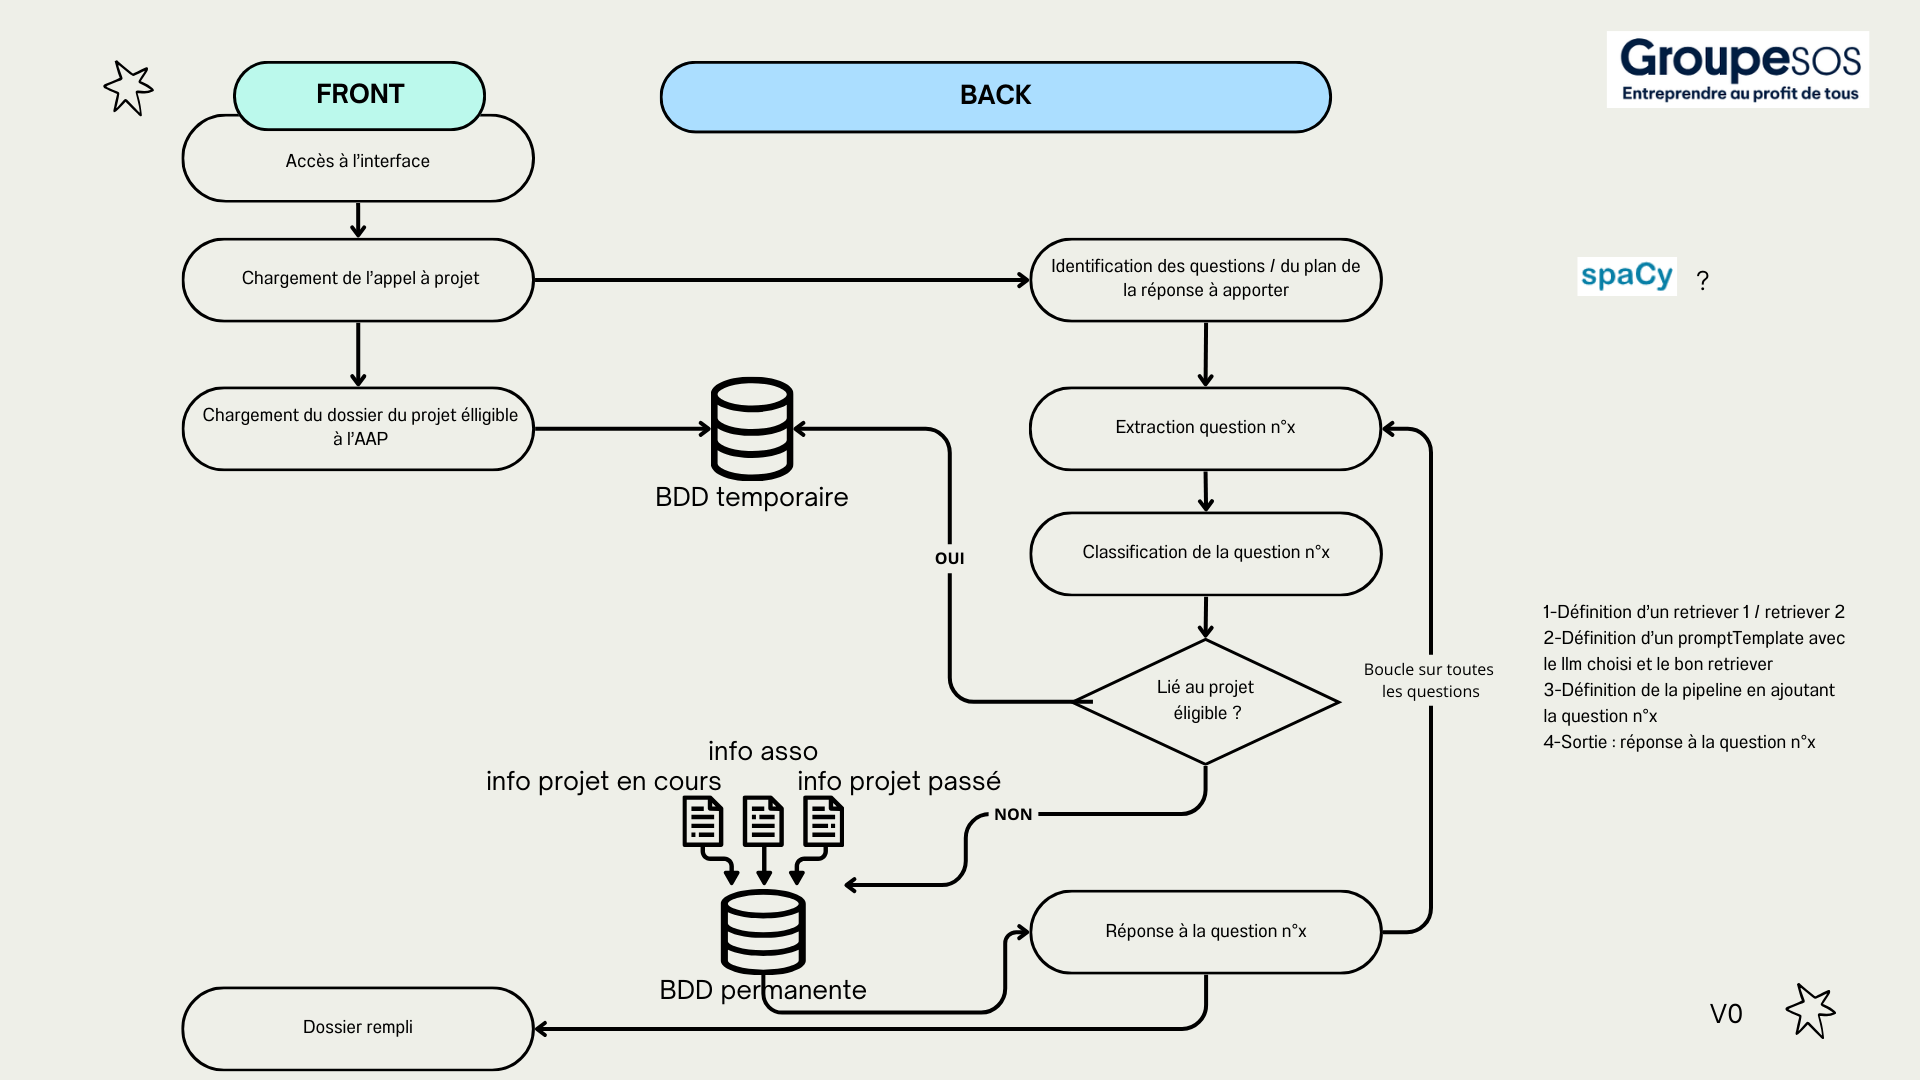

## Import des bibliothèques

In [10]:
!pip install pdfplumber pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 7.2 MB/s eta 0:00:00


In [19]:
!pip install chromadb sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.6 MB/s eta 0

In [14]:
!pip install langchain_community

In [19]:
!pip install langchain_chroma

In [40]:
!pip install langchain langchain-openai openai


In [46]:
# chargement des documents
import pdfplumber
import re

# création de la base de données chroma
import chromadb
from sentence_transformers import SentenceTransformer
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser



## Chargement du dossier d'AAP

### Loading des documents

In [3]:
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])
    return text

In [ ]:
# que du pdf ?
# pdf et word ?
# autre format ?

In [16]:
# exemple 1 d'un AAP
pdf_text = extract_text_from_pdf("PU_P01_AAP02.pdf")
print(pdf_text)

Description du projet
#question Ville et pays
Ce champ est requis.
#question Bénéficiaires visés
Âge, activité, catégorie socio-professionnelle, genre...
#question Nombre de personnes concernées
#question Contexte, environnement, justification et enjeux du projet
1000 caractères restants
#question Résumé du projet
1000 caractères restants
#question Date de début du projet
Date de fin du projet
Calendrier et étapes de réalisation du projet
1000 caractères restants
Votre projet est-il soutenu par un collaborateur du groupe Michelin ?
Dans le cas où le porteur de projet n'est pas salarié du groupe Michelin, veuillez
indiquer si vous bénéficiez de l'appui d'un collaborateur du groupe.
• Oui
• Non
Budget prévisionnel du projet
Montant global du projet (en Euros)
EUR
Montant du don demandé à la Fondation (en Euros)
EUR
Budget prévisionnel détaillé du projet
Budget détaillé de l'entité porteuse du projet pour l'année en cours
Lutte anti-corruption
Votre entité possède-t-elle un programme de c

In [5]:
# exemple 2 d'un AAP
pdf_text2 = extract_text_from_pdf("AppelAProjetOrg-piece_jointe-3267-1736247366.pdf")
print(pdf_text)

Appel à Projets
Janvier 2025
1. Thématique et objectifs de l’appel à projets :
Le Fonds de Dotation BIRD lance un appel à projets visant à soutenir des initiatives ayant un
impact significatif et durable. Cet appel vise à accompagner des initiatives innovantes et
concrètes qui répondent aux grands enjeux environnementaux et éducatifs :
1. Éducation des enfants dans les pays en voie de développement : favoriser l'accès à
une éducation de qualité pour les enfants dans des contextes défavorisés.
a. Mise en place ou amélioration des infrastructures éducatives (écoles,
bibliothèques, etc.).
b. Programmes éducatifs adaptés aux besoins locaux (alphabétisation,
compétences numériques, etc.).
c. Initiatives favorisant la scolarisation des filles et des enfants issus de milieux
marginalisés.
2. Protection des mers et océans : priorité aux actions de préservation de la biodiversité
marine en Méditerranée, ainsi qu’aux initiatives visant à lutter contre les pollutions
marines à l’échelle mondiale.

### Identification et extraction des questions

In [ ]:
# les formats d'AAP sont très différents - compliqué d'automatiser ou d'utiliser du regex
# pour le moment, j'ai mis des tag #questions devant les parties demandées dans l'AAP - tag à mettre directement depuis l interface

In [18]:
def extract_questions(text):
    pattern = r"#\s*question\s*(.+)"
    questions = re.findall(pattern, text, re.IGNORECASE)
    return [q.strip() for q in questions]

questions = extract_questions(pdf_text)

for idx, question in enumerate(questions, 1):
    print(f"{idx}. {question}")


1. Ville et pays
2. Bénéficiaires visés
3. Nombre de personnes concernées
4. Contexte, environnement, justification et enjeux du projet
5. Résumé du projet
6. Date de début du projet


Classification des questions

In [ ]:
# peut etre faut il ici aussi, indiquer manuellement dans quelle bdd l'information se trouve ?

## Chargement du projet elligible

In [11]:
pdf_loader = PyPDFLoader("Fiche projet fictive - scolarite.pdf")
documents = pdf_loader.load()
print(documents)

[Document(metadata={'producer': 'Microsoft: Print To PDF', 'creator': 'PyPDF', 'creationdate': '2025-02-16T12:35:35+01:00', 'author': '', 'moddate': '2025-02-16T12:35:35+01:00', 'title': 'Microsoft Word - Fiche projet fictive - scolarite', 'source': 'Fiche projet fictive - scolarite.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='FICHE PROJET – Lutte contre le décrochage scolaire à Rueil-Malmaison \n1- Nom du projet :  \n"Réussite pour Tous : Accompagnement et Remobilisation Scolaire" \n2- Contexte, constat enjeux et du projet : \nLe décrochage scolaire est un enjeu majeur à Rueil-Malmaison, touchant particulièrement les \njeunes issus de milieux socio-économiques défavorisés ou en difficulté d\'apprentissage. Selon \nles données de l\'Éducation nationale, une proportion significative d\'élèves décrochent avant \nl\'obtention d\'un diplôme, compromettant leur insertion professionnelle et sociale. \nLes causes du décrochage sont multiples : manque de motivation, dif

In [16]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n"," ",""],
    chunk_size=1000,
    chunk_overlap=200
    )

chunks = splitter.split_documents(documents)
print(chunks)

[Document(metadata={'producer': 'Microsoft: Print To PDF', 'creator': 'PyPDF', 'creationdate': '2025-02-16T12:35:35+01:00', 'author': '', 'moddate': '2025-02-16T12:35:35+01:00', 'title': 'Microsoft Word - Fiche projet fictive - scolarite', 'source': 'Fiche projet fictive - scolarite.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='FICHE PROJET – Lutte contre le décrochage scolaire à Rueil-Malmaison \n1- Nom du projet :  \n"Réussite pour Tous : Accompagnement et Remobilisation Scolaire" \n2- Contexte, constat enjeux et du projet : \nLe décrochage scolaire est un enjeu majeur à Rueil-Malmaison, touchant particulièrement les \njeunes issus de milieux socio-économiques défavorisés ou en difficulté d\'apprentissage. Selon \nles données de l\'Éducation nationale, une proportion significative d\'élèves décrochent avant \nl\'obtention d\'un diplôme, compromettant leur insertion professionnelle et sociale. \nLes causes du décrochage sont multiples : manque de motivation, dif

In [17]:
print([len(chunk.page_content) for chunk in chunks])

[963, 986, 886, 972, 629]


In [29]:
from google.colab import userdata
api_key=userdata.get('OPENAI_API_KEY')

if api_key:
    print("Clé API récupérée avec succès !")
else:
    print("Erreur : La clé API n'a pas été trouvée.")

Clé API récupérée avec succès !


In [78]:
embedding_model = OpenAIEmbeddings(api_key=api_key, model="text-embedding-3-small") #je changerai avec modele open source

persist_directory = "./chroma_db"

chroma_client = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding_model
    )

vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory=persist_directory,
    collection_name="project_docs"
)

vector_store.persist()

## Réponse à la question

### Création de retriever

In [70]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}
    )

### Création de Promptemplate

In [71]:
prompt = ChatPromptTemplate.from_template(
    """Use the following pieces of context to answer the question at the end.
    If you don't know the answer, say that you don't know.
    Context: {context}
    Question: {question}
    """
    )

### Création des pipelines

In [72]:
llm = ChatOpenAI(model="gpt-4o", api_key="api_key", temperature=0)

In [73]:
# test retriever
test_result = retriever.invoke("Dans quelle ville et pays ont lieu ce projet?")
print(test_result)

[Document(metadata={'author': '', 'creationdate': '2025-02-16T12:35:35+01:00', 'creator': 'PyPDF', 'moddate': '2025-02-16T12:35:35+01:00', 'page': 0, 'page_label': '1', 'producer': 'Microsoft: Print To PDF', 'source': 'Fiche projet fictive - scolarite.pdf', 'title': 'Microsoft Word - Fiche projet fictive - scolarite', 'total_pages': 2}, page_content="perspectives d'avenir. \nL'enjeu de ce projet est donc de prévenir et réduire le décrochage scolaire en mettant en place \ndes dispositifs d'accompagnement personnalisé, d'orientation et de soutien scolaire pour \nfavoriser la réussite éducative et l'intégration sociale des jeunes en difficulté. \n3- Objectifs du projet : \nObjectif global : \nRéduire le taux de décrochage scolaire à Rueil-Malmaison en accompagnant les élèves en \ndifficulté vers la réussite éducative et l'insertion professionnelle. \nObjectifs spécifiques : \n\uf0b7 Offrir un accompagnement individualisé aux jeunes en risque de décrochage. \n\uf0b7 Renforcer la motivation

In [74]:
chain = ({"context": retriever,
          "question": RunnablePassthrough()}|
         prompt|
         llm|
         StrOutputParser()
         )

In [75]:
result = chain.invoke({"question": "Dans quelle ville et pays ont lieu ce projet?"}) # passer la 1ere question identifiée qui n'est pas toujours écrite en langage naturel
print(result)

TypeError: argument 'text': 'dict' object cannot be converted to 'PyString'